# Play around with Cats and Dogs classification using Kaggle data set

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision #for data transformation
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import helper

In [2]:
data_dir = 'Cat_Dog_data'

batch_size = 32

classes = ['cat','dog']

# TODO: Define transforms for the training data and testing data
train_transforms_spec = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation(45),
                                            transforms.Resize(110),
                                            transforms.CenterCrop(100),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.3, 0.3, 0.3), (0.5, 0.5, 0.5))
                                           ])
                                            #normalize: input = (input - mean) / std

test_transforms_spec = transforms.Compose([transforms.Resize((100,100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.3, 0.3, 0.3), (0.5, 0.5, 0.5))
                                          ])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms_spec)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms_spec)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([3, 100, 100])


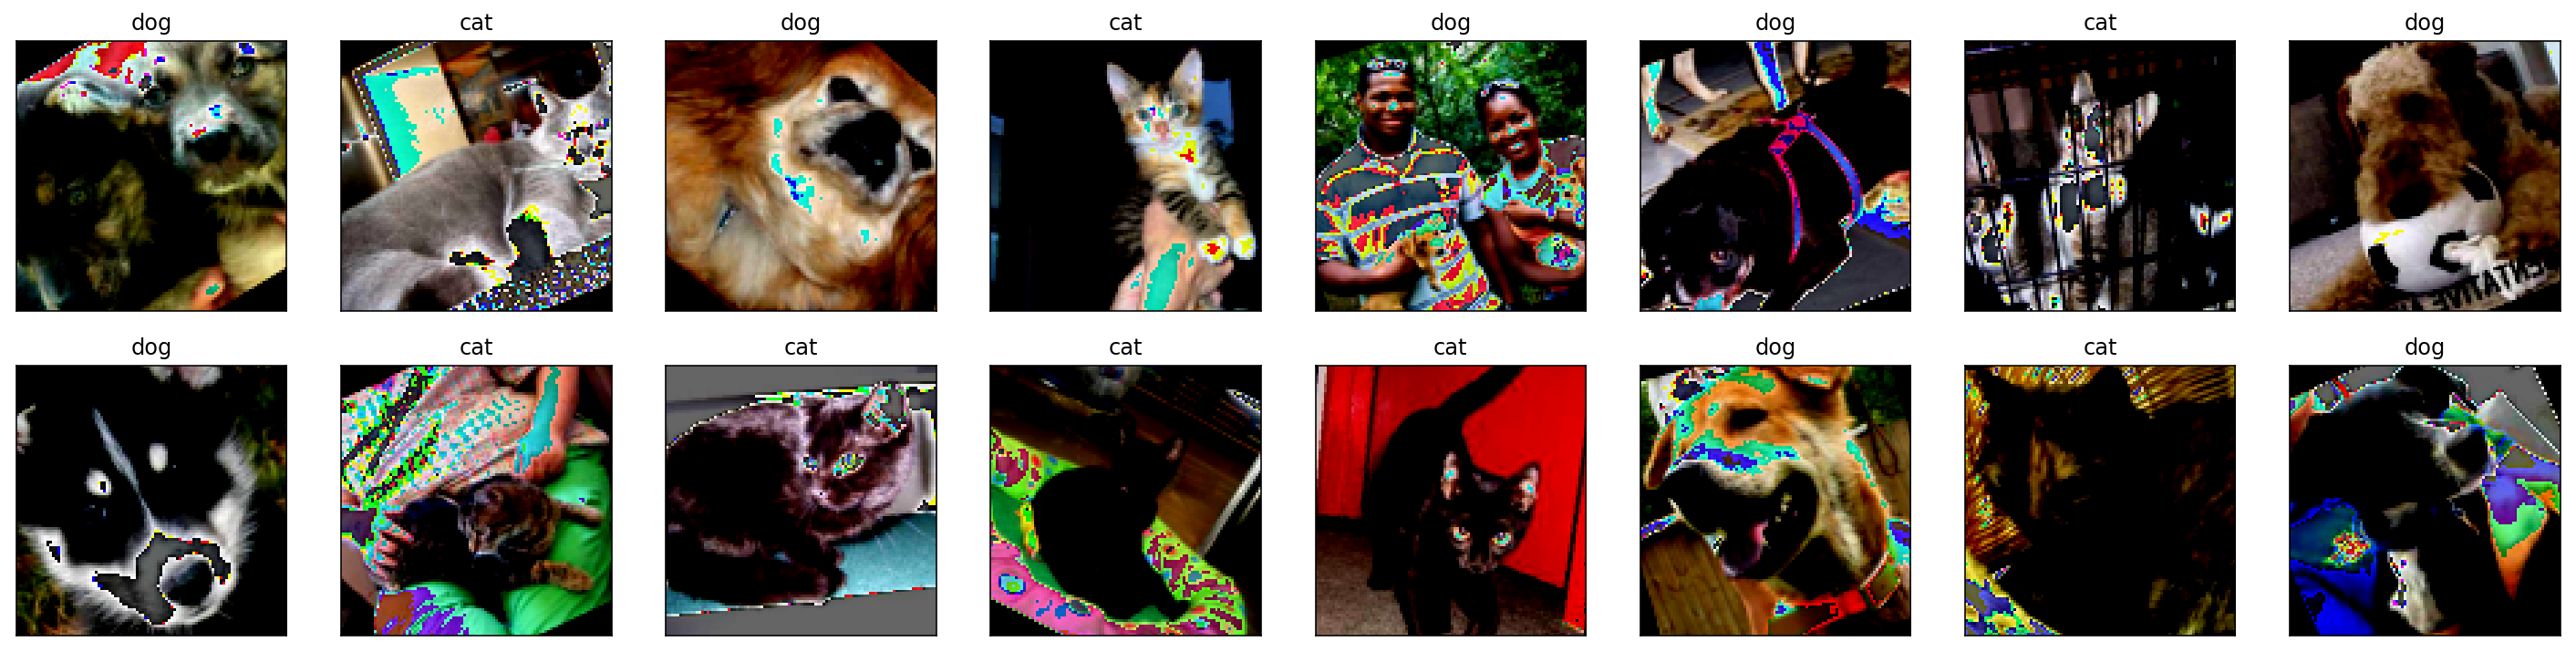

In [3]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
print(images[0].shape)
    
fig = plt.figure(figsize=(25, 6))
for idx in range(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    clipped_img = np.clip(np.transpose(images[idx].numpy(),(1,2,0)),0,255)
    ax.imshow(clipped_img)
    ax.set_title(classes[labels[idx].numpy()])

In [4]:
# Optional TODO: Attempt to build a network to classify cats vs dogs from this dataset
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # input size: 3 x 100 x 100

        # conv layer 1:
        # 3 input image channel (RGB), 16 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F+2P)/S +1 = (100-5)/1 +1 = 96
        # the output Tensor for one image, will have the dimensions: (64, 96, 96)
        self.conv1 = nn.Conv2d(3, 64, 5)

        # maxpool layer 1
        # pool with kernel_size=2, stride=2
        # after one pool layer, this becomes (64, 48, 48)
        self.pool1 = nn.MaxPool2d(2, 2)        
        
        # conv layer 2:
        ## output size = (W-F+2P)/S +1 = (48-3)/1 +1 = 46
        # the output Tensor for one image, will have the dimensions: (64, 46, 46)
        self.conv2 = nn.Conv2d(64, 64, 3)
        
        # maxpool layer 2
        # pool with kernel_size=2, stride=2
        # after one pool layer, this becomes (64, 23, 23) #rounded down
        self.pool2 = nn.MaxPool2d(2, 2)   
        
        # conv layer 3:
        ## output size = (W-F+2P)/S +1 = (23-3)/1 +1 = 21
        # the output Tensor for one image, will have the dimensions: (128, 21, 21)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        # maxpool layer 3
        # pool with kernel_size=2, stride=2
        # after one pool layer, this becomes (128, 10, 10) #rounded down
        self.pool3 = nn.MaxPool2d(2, 2)  
        
        # conv layer 4:
        ## output size = (W-F+2P)/S +1 = (10-3)/1 +1 = 8
        # the output Tensor for one image, will have the dimensions: (256, 8, 8)
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        # maxpool layer 4
        # pool with kernel_size=2, stride=2
        # after one pool layer, this becomes (256, 4, 4) #rounded down
        self.pool4 = nn.MaxPool2d(2, 2)         
        
        self.dropout1 = nn.Dropout(p=0.2)
        
        # 256 outputs * the 4*4 filtered/pooled map size
        # 256 output channels 
        self.fc1 = nn.Linear(256*4*4, 256)
        
        self.fc2 = nn.Linear(256, 256)
        
        self.fc3 = nn.Linear(256, 128)

        self.fc4 = nn.Linear(128, 16)        
        
        # 2 output channels (for the 2 classes)
        self.fc5 = nn.Linear(16, 2)     
        
        self.dropout2 = nn.Dropout(p=0.5)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool1(F.relu(self.conv1(x)))       
        
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout1(x)
        
        # prep for linear layer
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)

        # one linear layer
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)

        # one linear layer
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)        
        
        # one linear layer
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)  
        
        # one linear layer
        x = F.relu(self.fc4(x))
        x = self.dropout2(x)  
        
        # one linear layer
        x = self.fc5(x)
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=2, bias=True)
  (dropout2): Dropout(p=0.5)
)


In [5]:
#load the saved model
model_dir = 'saved_models/'
model_name = 'cats_and_dogs2.pt'

state_dict = torch.load(model_dir+model_name)
print(state_dict.keys())

net.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias'])


In [6]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.NLLLoss()

## TODO: specify optimizer 
# stochastic gradient descent with a small learning rate
optimizer = optim.RMSprop(net.parameters(), lr=0.0000001)

In [7]:
# Calculate accuracy before training
correct = 0
total = 0

net.to(device)

# Iterate through test dataset
for images, labels in testloader:

    images, labels = images.to(device), labels.to(device) #just in case there is GPU
    
    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(torch.exp(outputs.data), 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Test Accuracy before training: ', accuracy)

Test Accuracy before training:  91.0


In [8]:
# Implement a function for the validation pass
def validation(net, test_loader, criterion):
    test_loss = 0
    correct_count  = 0
    
    net.to(device)
    
    # set the module to evaluation mode
    net.eval()

    for batch_i, data in enumerate(test_loader): #total 79 testing batch
        #print(len(test_loader))

        # get the input images and their corresponding labels
        inputs, labels = data #32 x 1 x 28 x 28; 32
        
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass to get outputs
        outputs = net(inputs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update average test loss 
        test_loss += loss
        
        # get the predicted class from the maximum value in the output-list of class scores
        ps = torch.exp(outputs.data)
        
        assert(ps.max().le(1))
        
        _, predicted = torch.max(ps, 1)

        # compare predictions to true label
        # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
        correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
        correct_count += correct.sum().to('cpu').numpy()
    
    test_loss_avg = test_loss/(len(test_loader))
    test_avg_acc = correct_count/(len(test_loader)*batch_size)
    
    return test_loss_avg, test_avg_acc

In [9]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    net.train()
    print_every = 200
    
    net.to(device)
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0 
        
        for batch_i, data in enumerate(trainloader): #total 704 training batch
            
            # get the input images and their corresponding labels
            inputs, labels = data
            
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()

            if (batch_i+1) % print_every == 0:    # print every x batches. batch id start with 0
                
                with torch.no_grad():
                    test_loss, accuracy = validation(net, testloader, criterion)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Running Traing Loss: {:.5f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.5f}.. ".format(test_loss),
                      "Test Accuracy: {:.2f}".format(accuracy))                
                
                avg_loss = running_loss/print_every
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                running_loss = 0.0

            # Make sure training is back on
            net.train()

    print('Finished Training')
    return loss_over_time

In [10]:
training_loss = []

In [16]:
# define the number of epochs to train for
n_epochs = 10 # start small to see if your model works, initially

# call train and record the loss over time
training_loss.extend(train(n_epochs))

Epoch: 1/10..  Running Traing Loss: 0.10063..  Test Loss: 0.19934..  Test Accuracy: 0.91
Epoch: 1/10..  Running Traing Loss: 0.08591..  Test Loss: 0.20009..  Test Accuracy: 0.91
Epoch: 1/10..  Running Traing Loss: 0.08854..  Test Loss: 0.19917..  Test Accuracy: 0.91
Epoch: 2/10..  Running Traing Loss: 0.10324..  Test Loss: 0.20089..  Test Accuracy: 0.91
Epoch: 2/10..  Running Traing Loss: 0.08909..  Test Loss: 0.20104..  Test Accuracy: 0.91
Epoch: 2/10..  Running Traing Loss: 0.08866..  Test Loss: 0.19987..  Test Accuracy: 0.91
Epoch: 3/10..  Running Traing Loss: 0.08389..  Test Loss: 0.20073..  Test Accuracy: 0.91
Epoch: 3/10..  Running Traing Loss: 0.08790..  Test Loss: 0.20042..  Test Accuracy: 0.91
Epoch: 3/10..  Running Traing Loss: 0.08979..  Test Loss: 0.20036..  Test Accuracy: 0.91
Epoch: 4/10..  Running Traing Loss: 0.09566..  Test Loss: 0.20083..  Test Accuracy: 0.91
Epoch: 4/10..  Running Traing Loss: 0.09274..  Test Loss: 0.20103..  Test Accuracy: 0.91
Epoch: 4/10..  Runnin

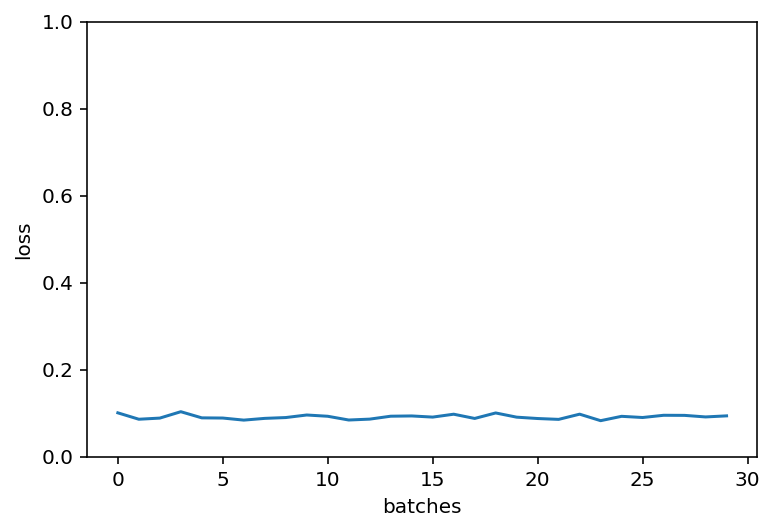

In [19]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('batches')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.show()

In [20]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

net.to(device)
# set the module to evaluation mode

net.eval()

for batch_i, data in enumerate(testloader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    inputs, labels = inputs.to(device), labels.to(device)
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.199012

Test Accuracy of   cat: 86% (1086/1250)
Test Accuracy of   dog: 96% (1204/1250)

Test Accuracy (Overall): 91% (2290/2500)


In [21]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'cats_and_dogs2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)